In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/home/nathaniel/Dropbox/Projects/tsdate-ep/debug-constraints':
  os.chdir(r'/home/nathaniel/Dropbox/Projects/tsdate-ep/debug-constraints')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/tmp/ipykernel_1128129/649199665.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/home/nathaniel/.local/miniconda3/lib/python3.9/importlib/_bootstrap.py": 1694440275.1108675, "/home/nathaniel/.local/miniconda3/lib/python3.9/importlib/_bootstrap_external.py": 1694440275.1108675, "/home/nathaniel/.local/miniconda3/lib/python3.9/codecs.py": 1694440273.9388885, "/home/nathaniel/.local/miniconda3/lib/python3.9/encodings/aliases.py": 1694440275.3668628, "/home/nathaniel/.local/miniconda3/lib/python3.9/encodings/__init__.py": 1694440275.4308617, "/home/nathaniel/.local/miniconda3/lib/python3.9/encodings/utf_8.py": 1694440275.4788609, "/home/nathaniel/.local/miniconda3/lib/python3.9/encodings/latin_1.py": 1694440275.4548612, "/home/nathaniel/.local/miniconda3/lib/python3.9/abc.py": 1694440273.922889, "/home/nathaniel/.local/miniconda3/lib/python3.9/io.py": 1694440273.974888, "/home/nathaniel/.local/miniconda3/lib/python3.9/stat.py": 1694440274.0468867, "/home/nathaniel/.local/miniconda3/lib/python3.9/_collections_abc.py": 1694440273.9428885, "/home/nathaniel/.local/minic

In [2]:
import os
import json
import tsdate
import tskit
import numpy as np
import msprime
import matplotlib.pyplot as plt

np.random.seed(1024)

In [3]:
mu = 1.25e-8
Ne = 1e4
if os.path.exists("example.trees"):
  ts = tskit.load("example.trees")
else:
  ts = msprime.sim_ancestry(
      samples=100,
      sequence_length=1e6, 
      recombination_rate=1e-8, 
      population_size=Ne,
      random_seed=101,
  )
  ts = msprime.sim_mutations(
      ts,
      rate=mu,
      random_seed=101,
  )
  ts.dump("example.trees")

In [4]:
node_spans = np.bincount(
    ts.edges_child,
    weights=ts.edges_right - ts.edges_left,
    minlength=ts.num_nodes,
)
for t in ts.trees(): node_spans[t.root] += t.span

In [5]:
smallest_child_span = np.full(ts.num_nodes, np.inf)
samples = set(ts.samples())
for p, c in zip(ts.edges_parent, ts.edges_child):
  if c not in samples:
    smallest_child_span[p] = min(
        smallest_child_span[p], node_spans[c]
    )
smallest_child_span[np.isinf(smallest_child_span)] = np.nan

Focal parent is node 278


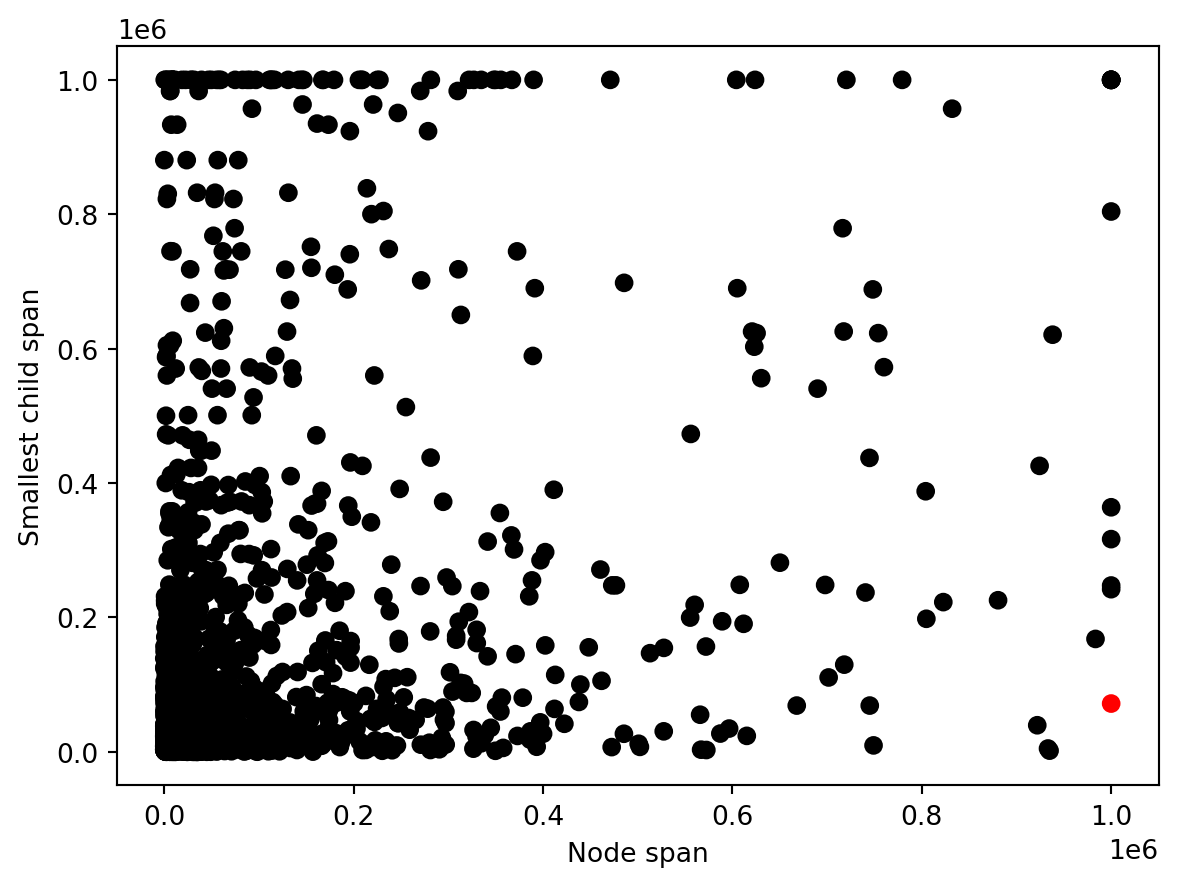

In [6]:
target = np.logical_and(
  node_spans > 0.8e6, smallest_child_span < 0.1e6
)
colors = ['black' for _ in target]
focal = np.flatnonzero(target)[0]
colors[focal] = 'red'
plt.scatter(
    node_spans, 
    smallest_child_span, 
    c=colors,
)
plt.xlabel("Node span")
plt.ylabel("Smallest child span")
plt.draw()
print(f"Focal parent is node {focal}")

In [7]:
to_roots = np.full(ts.num_nodes, False)
to_roots[focal] = True
for p, c in zip(ts.edges_parent, ts.edges_child):
  to_roots[p] |= to_roots[c]
to_roots[focal] = False
print(f"{np.sum(to_roots)} nodes on paths between {focal} and roots")

to_leaves = np.full(ts.num_nodes, False)
to_leaves[focal] = True
for p, c in zip(ts.edges_parent[::-1], ts.edges_child[::-1]):
  to_leaves[c] |= to_leaves[p]
to_leaves[focal] = False
print(f"{np.sum(to_leaves)} nodes on paths between {focal} and leaves")
  
assert np.all(ts.nodes_time[to_leaves] < ts.nodes_time[focal])
assert np.all(ts.nodes_time[to_roots] > ts.nodes_time[focal])

874 nodes on paths between 278 and roots
6 nodes on paths between 278 and leaves


In [8]:
# (this doesn't include roots, TODO)
edges_to_leaves = to_leaves[ts.edges_child]
edges_to_leaves = [
  (l, r, c) for l,r,c in zip(
    ts.edges_left[edges_to_leaves],
    ts.edges_right[edges_to_leaves],
    ts.edges_child[edges_to_leaves],
  )
]

edges_to_roots = to_roots[ts.edges_child]
edges_to_roots = [
  (l, r, c) for l,r,c in zip(
    ts.edges_left[edges_to_roots],
    ts.edges_right[edges_to_roots],
    ts.edges_child[edges_to_roots],
  )
]

edges_at_focal = (ts.edges_child == focal)
edges_at_focal = [
  (l, r, c) for l,r,c in zip(
    ts.edges_left[edges_at_focal],
    ts.edges_right[edges_at_focal],
    ts.edges_child[edges_at_focal],
  )
]

/tmp/ipykernel_1128129/576521543.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()


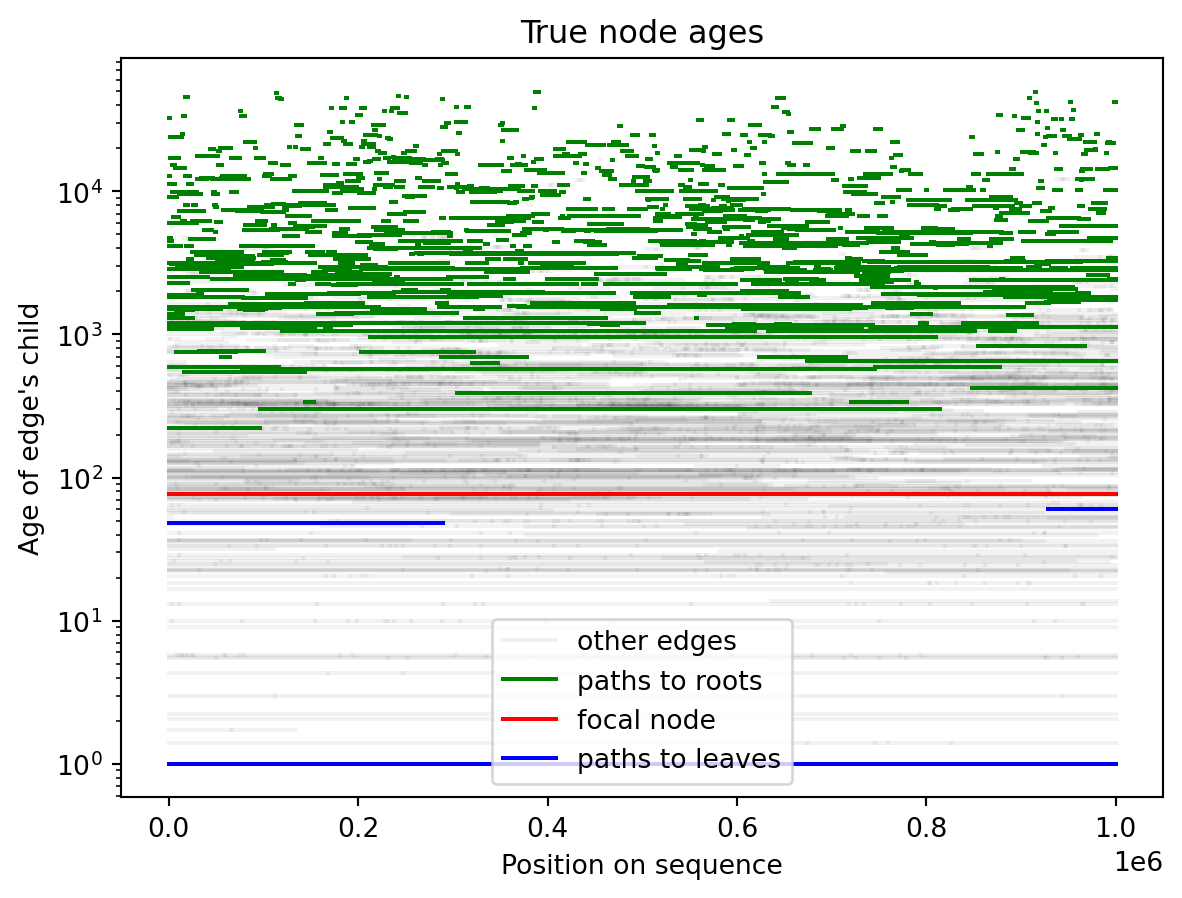

In [9]:
def edges_plot(nodes_time, title):
  """ 
  Plot collections of edges defined above.
  Add 1 to node ages so that samples show at time 0
  on log-transformed y-axis.
  """
  label = 'other edges'
  for l, r, c in zip(ts.edges_left, ts.edges_right, ts.edges_child):
    t = nodes_time[c] + 1
    plt.plot([l, r], [t, t], c='black', label=label, alpha=0.05)
    label = None
  label = 'paths to roots'
  for l, r, c in edges_to_roots:
    t = nodes_time[c] + 1
    plt.plot([l, r], [t, t], c='green', label=label)
    label = None
  label = 'focal node'
  for l, r, c in edges_at_focal:
    t = nodes_time[c] + 1
    plt.plot([l, r], [t, t], c='red', label=label)
    label = None
  label = 'paths to leaves'
  for l, r, c in edges_to_leaves:
    t = nodes_time[c] + 1
    plt.plot([l, r], [t, t], c='blue', label=label)
    label = None
  plt.xlabel("Position on sequence")
  plt.ylabel("Age of edge's child")
  plt.yscale("log")
  plt.legend()
  plt.title(title)
  plt.draw()

edges_plot(ts.nodes_time, "True node ages")

In [10]:
tmp = 0
for l, r, c in edges_to_leaves:
  if c not in samples and l > tmp: 
    tmp = l
    focal_child = c
print(f"Focal child is node {focal_child}")

Focal child is node 258


/tmp/ipykernel_1128129/576521543.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()


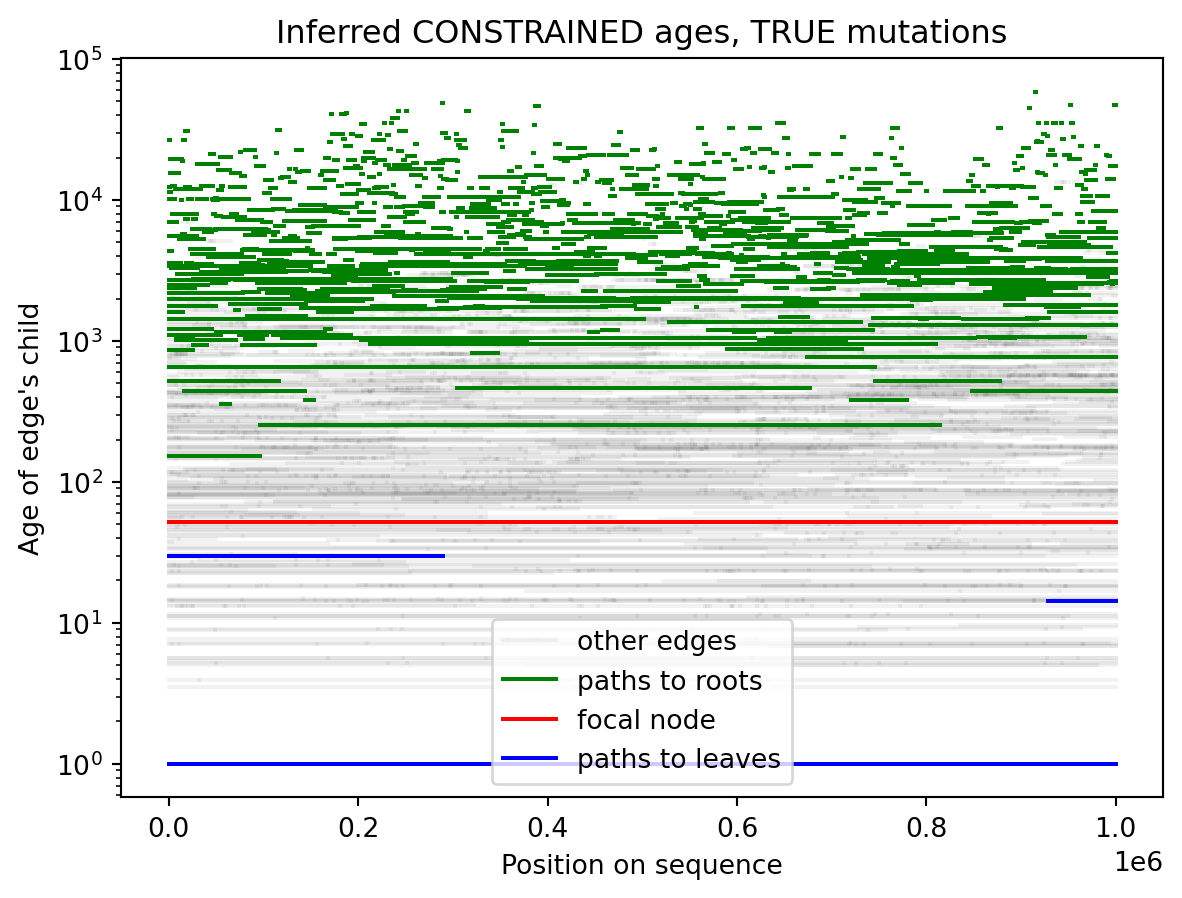

In [11]:
dts = tsdate.date(
  ts, population_size=1e4, mutation_rate=mu, method="variational_gamma"
)

edges_plot(dts.nodes_time, "Inferred CONSTRAINED ages, TRUE mutations")

/tmp/ipykernel_1128129/576521543.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()


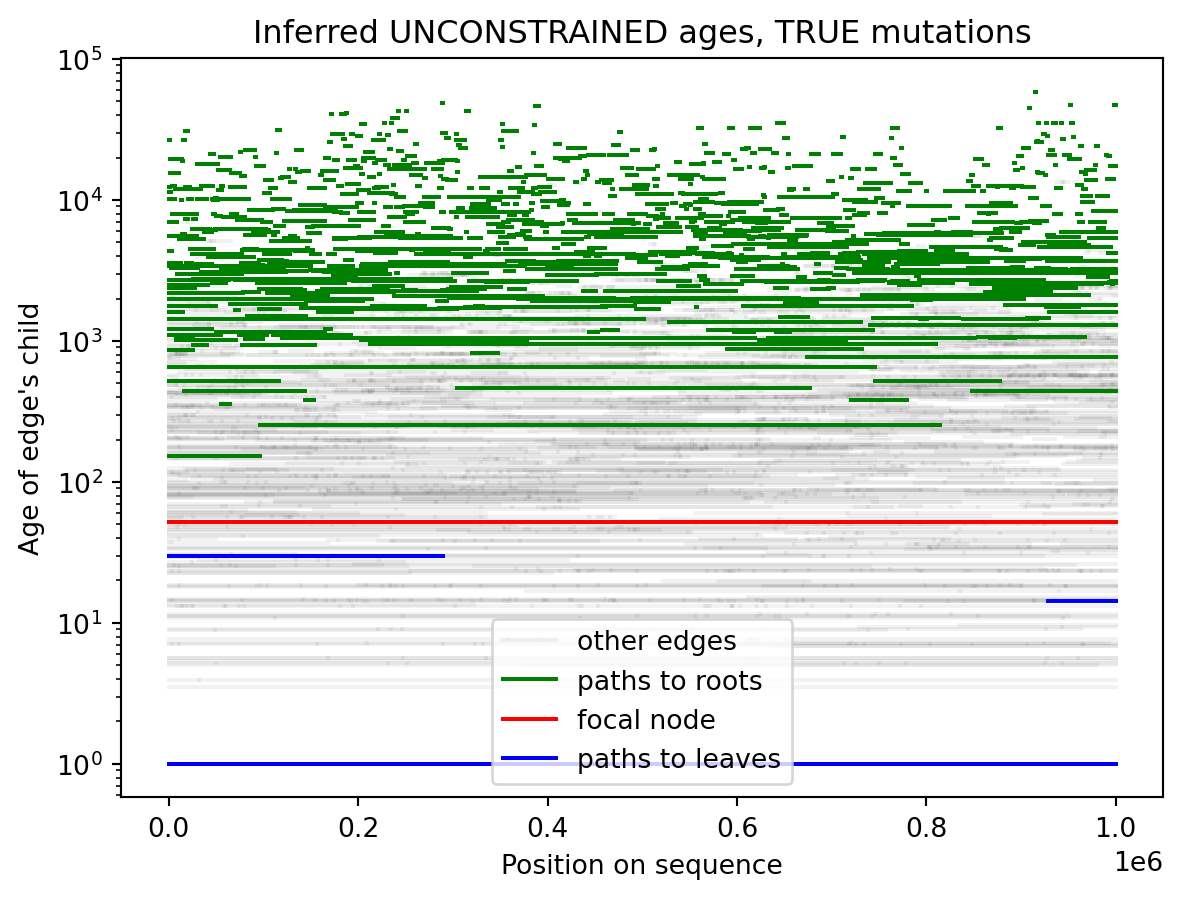

In [12]:
dts_unconstr = np.array([
  json.loads(n.metadata or '{"mn":0}')['mn'] for n in dts.nodes()
])

edges_plot(dts_unconstr, "Inferred UNCONSTRAINED ages, TRUE mutations")

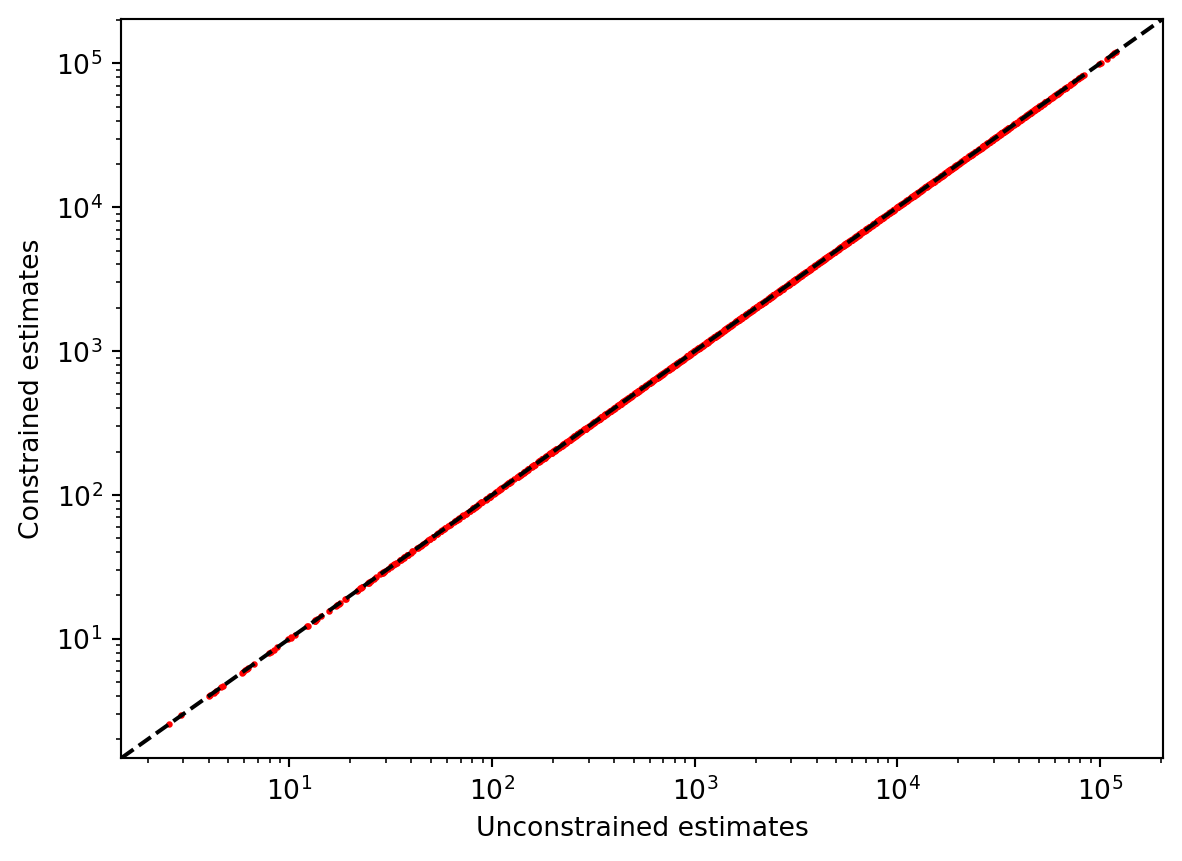

In [13]:
plt.scatter(dts_unconstr, dts.nodes_time, c='red', s=2)
plt.axline((10,10), (100,100), c='black', linestyle='--')
plt.xlabel("Unconstrained estimates")
plt.ylabel("Constrained estimates")
plt.xscale('log')
plt.yscale('log')
plt.draw()

In [14]:
# figure out which edges to add mutations to
left_bound = min(
    [l for (l, r, c) in edges_to_leaves if c == focal_child]
)
edges_to_perturb = np.logical_and(
    ts.edges_parent == focal_child,
    ts.edges_left >= left_bound,
)
print("Edges to add bogus mutations to:")
for l, r, p, c in zip(
    ts.edges_left[edges_to_perturb],
    ts.edges_right[edges_to_perturb],
    ts.edges_parent[edges_to_perturb],
    ts.edges_child[edges_to_perturb],
):
    print(f"left: {l}, right: {r}, parent: {p}, child: {c}")

bogus_mutations = 1000
new_mut_edges = np.random.choice(
  np.flatnonzero(edges_to_perturb),
  size=bogus_mutations,
)
new_mut_nodes = ts.edges_child[new_mut_edges]

# figure out what locations to add new sites
existing_sites = [s.position for s in ts.sites()]
new_sites = np.setdiff1d(
    np.arange(left_bound, ts.sequence_length), existing_sites
)
np.random.shuffle(new_sites)
new_sites = new_sites[:bogus_mutations]

print(f"Adding {bogus_mutations} new sites from {min(new_sites)} to {max(new_sites)} bp")

# make a new ts with a bunch of mutations on these edges
tables = ts.dump_tables()
for pos, node in zip(new_sites, new_mut_nodes):
  id = tables.sites.add_row(position=pos, ancestral_state="G")
  tables.mutations.add_row(
    site=id, node=node, derived_state="A", time=tskit.UNKNOWN_TIME
  )
tables.sort()
ts_perturb = tables.tree_sequence()
assert ts_perturb.num_mutations == ts.num_mutations + bogus_mutations
assert np.allclose(ts_perturb.nodes_time, ts.nodes_time)

Edges to add bogus mutations to:
left: 928083.0, right: 1000000.0, parent: 258, child: 58
left: 928083.0, right: 1000000.0, parent: 258, child: 106
Adding 1000 new sites from 928153.0 to 999987.0 bp


/tmp/ipykernel_1128129/576521543.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()


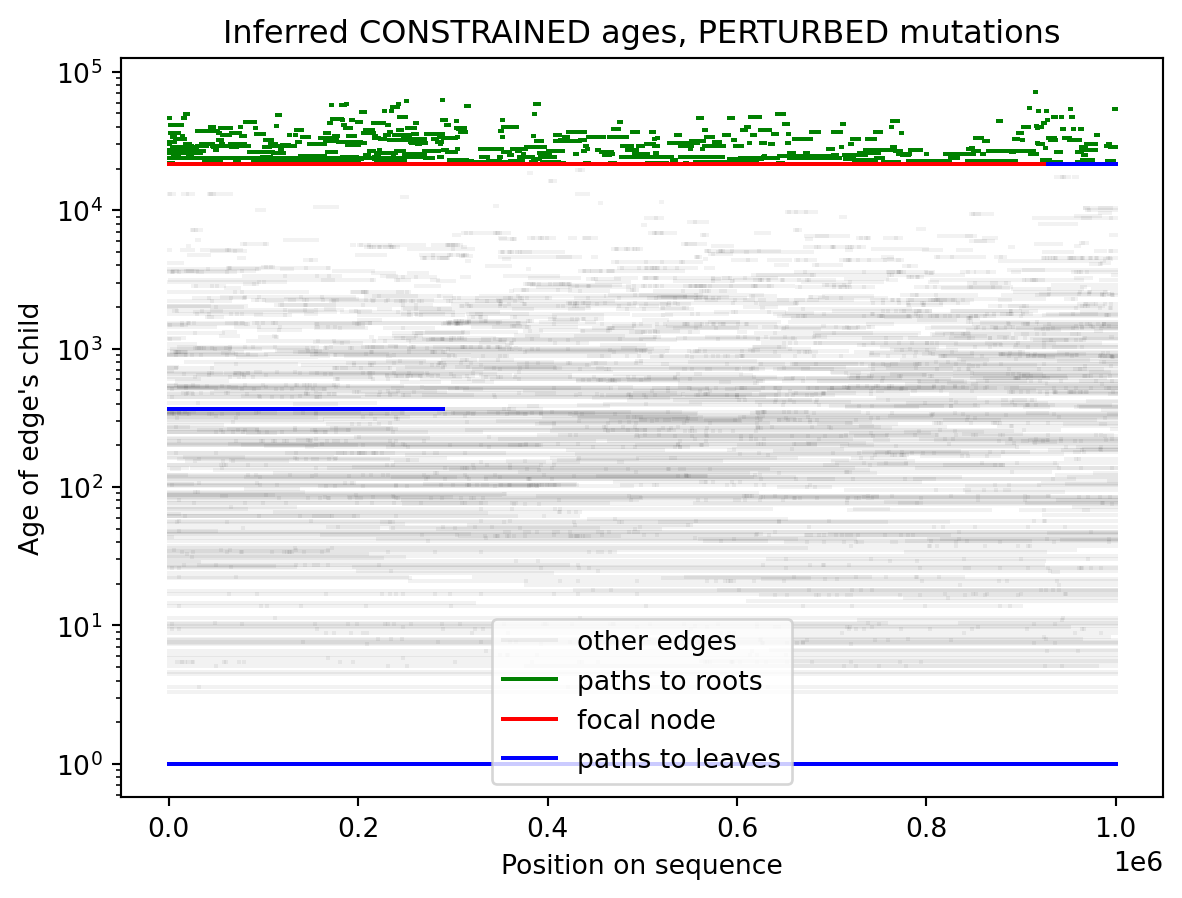

In [15]:
dts_perturb = tsdate.date(
  ts_perturb, population_size=1e4, mutation_rate=mu, method="variational_gamma",
  max_iterations=1,
)

edges_plot(dts_perturb.nodes_time, "Inferred CONSTRAINED ages, PERTURBED mutations")

/tmp/ipykernel_1128129/576521543.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()


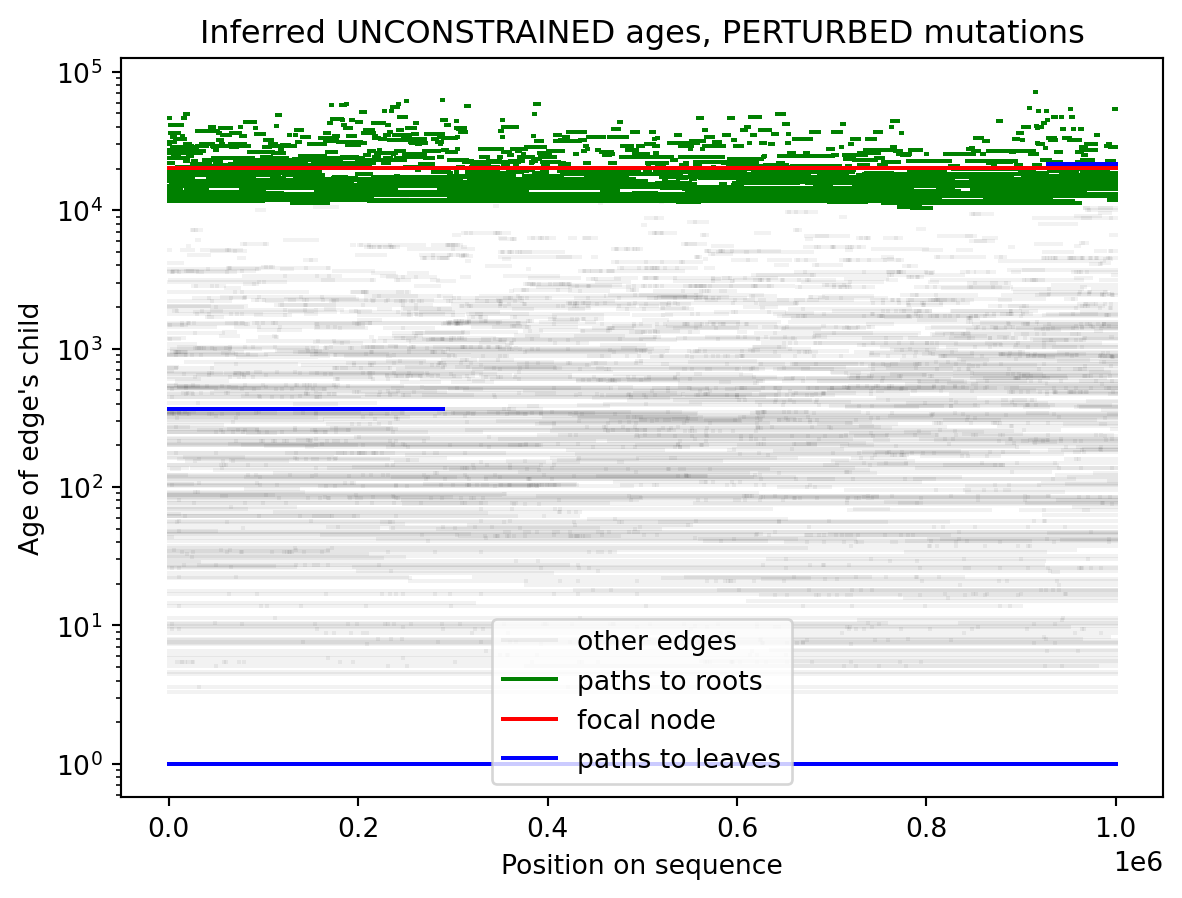

In [16]:
dts_perturb_unconstr = np.array([
  json.loads(n.metadata or '{"mn":0}')['mn'] for n in dts_perturb.nodes()
])

edges_plot(dts_perturb_unconstr, "Inferred UNCONSTRAINED ages, PERTURBED mutations")

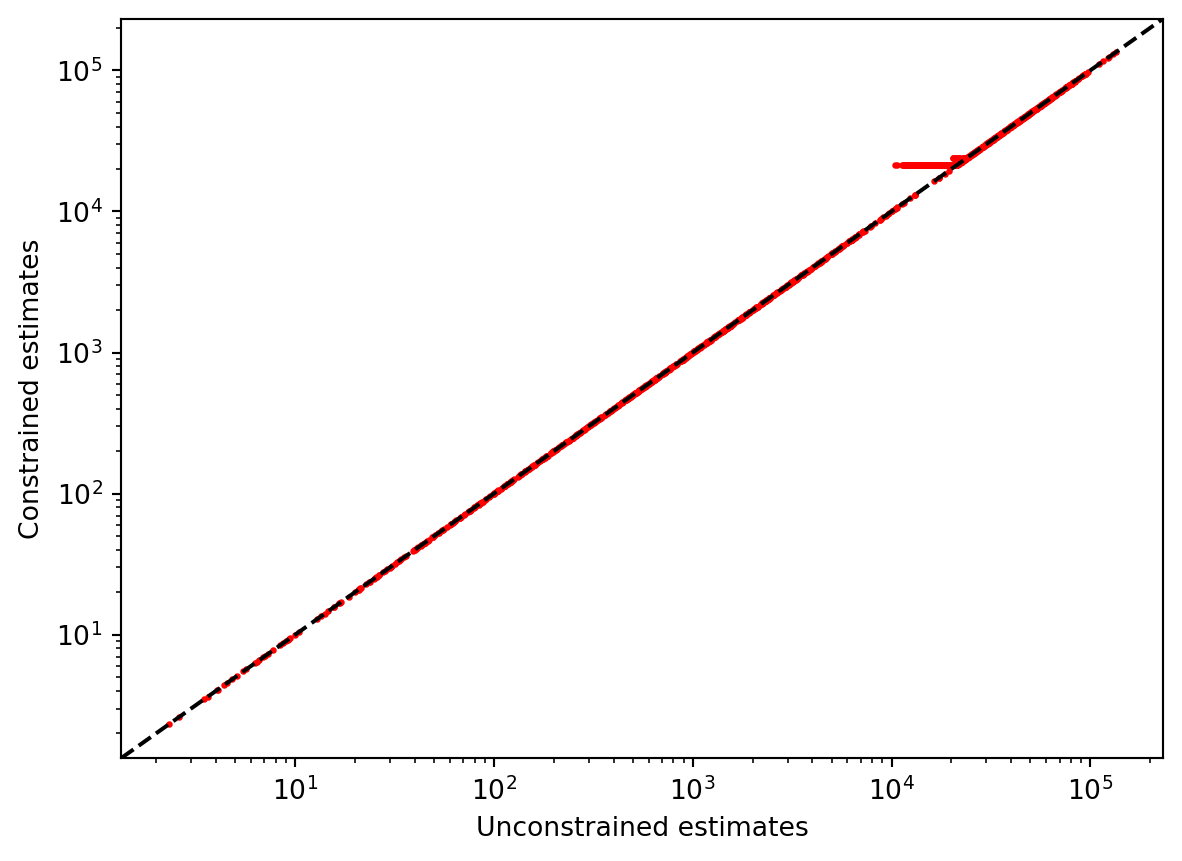

In [17]:
plt.scatter(dts_perturb_unconstr, dts_perturb.nodes_time, c='red', s=2)
plt.axline((10,10), (100,100), c='black', linestyle='--')
plt.xlabel("Unconstrained estimates")
plt.ylabel("Constrained estimates")
plt.xscale('log')
plt.yscale('log')
plt.draw()